# H2O.ai

In [311]:
import sys
lib_dir = "../../libs/"
if lib_dir not in sys.path:
    sys.path.append(lib_dir)

In [312]:
import automl

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

In [313]:
#h2o.cluster().shutdown()

In [314]:
h2o.init(min_mem_size=6)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 hours 21 mins
H2O cluster timezone:,Europe/Amsterdam
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.2
H2O cluster version age:,4 months and 6 days !!!
H2O cluster name:,H2O_from_python_rafael_j9vh10
H2O cluster total nodes:,1
H2O cluster free memory:,5.594 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [315]:
df = pd.read_pickle('../../data/Visual_well_being/merged_features.pickle')

In [316]:
df.head()

,age,user_followed_by,user_follows,user_posted_photos,Person,Plant,Food,Collage,Outdoors,Book,...,employed,income,participate,P,E,R,M,A,PERMA,imagecount
0,42.0,364.0,814.0,2037.0,0.220913,0.034855,0.013746,0.025037,0.021600,0.010309,...,0,5,1,3.000000,5.333333,3.666667,5.333333,5.333333,4.4375,1515.0
1,36.0,198.0,288.0,124.0,0.306452,0.008065,0.056452,0.008065,0.008065,0.000000,...,2,6,1,7.666667,8.333333,7.333333,7.666667,8.000000,7.8750,123.0
2,21.0,311.0,240.0,350.0,0.482857,0.005714,0.037143,0.057143,0.000000,0.011429,...,3,1,1,4.666667,8.000000,6.333333,4.666667,5.000000,5.6875,350.0
3,37.0,732.0,943.0,610.0,0.191803,0.011475,0.011475,0.011475,0.011475,0.001639,...,6,1,1,10.000000,9.333333,10.000000,9.333333,7.666667,9.2500,609.0
4,29.0,24.0,65.0,64.0,0.281250,0.125000,0.000000,0.015625,0.015625,0.031250,...,2,2,1,6.333333,4.666667,8.333333,5.666667,8.333333,6.6250,64.0


In [317]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 158
Data columns (total 90 columns):
age                                           159 non-null float64
user_followed_by                              159 non-null float64
user_follows                                  159 non-null float64
user_posted_photos                            159 non-null float64
Person                                        159 non-null float64
Plant                                         159 non-null float64
Food                                          159 non-null float64
Collage                                       159 non-null float64
Outdoors                                      159 non-null float64
Book                                          159 non-null float64
Sky                                           159 non-null float64
Alcohol                                       159 non-null float64
Crowd                                         159 non-null float64
Toy                     

## Correlated Columns

In [318]:
def drop_correlated_columns(df, threshold, target):

    aux = df.copy().drop(target, axis=1)
    result = df.copy()
    
    # Create correlation matrix
    corr_matrix = aux.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop features 
    
    to_drop = [column for column in to_drop if column not in target_features]
    
    print(to_drop)
    
    result.drop(to_drop, axis=1)
    
    return result

In [319]:
target_features = ['P', 'E', 'R', 'M', 'A', 'PERMA']

# Get correlated columns

#df = drop_correlated_columns(df, 0.8, target_features)

In [320]:
df.shape

(159, 90)

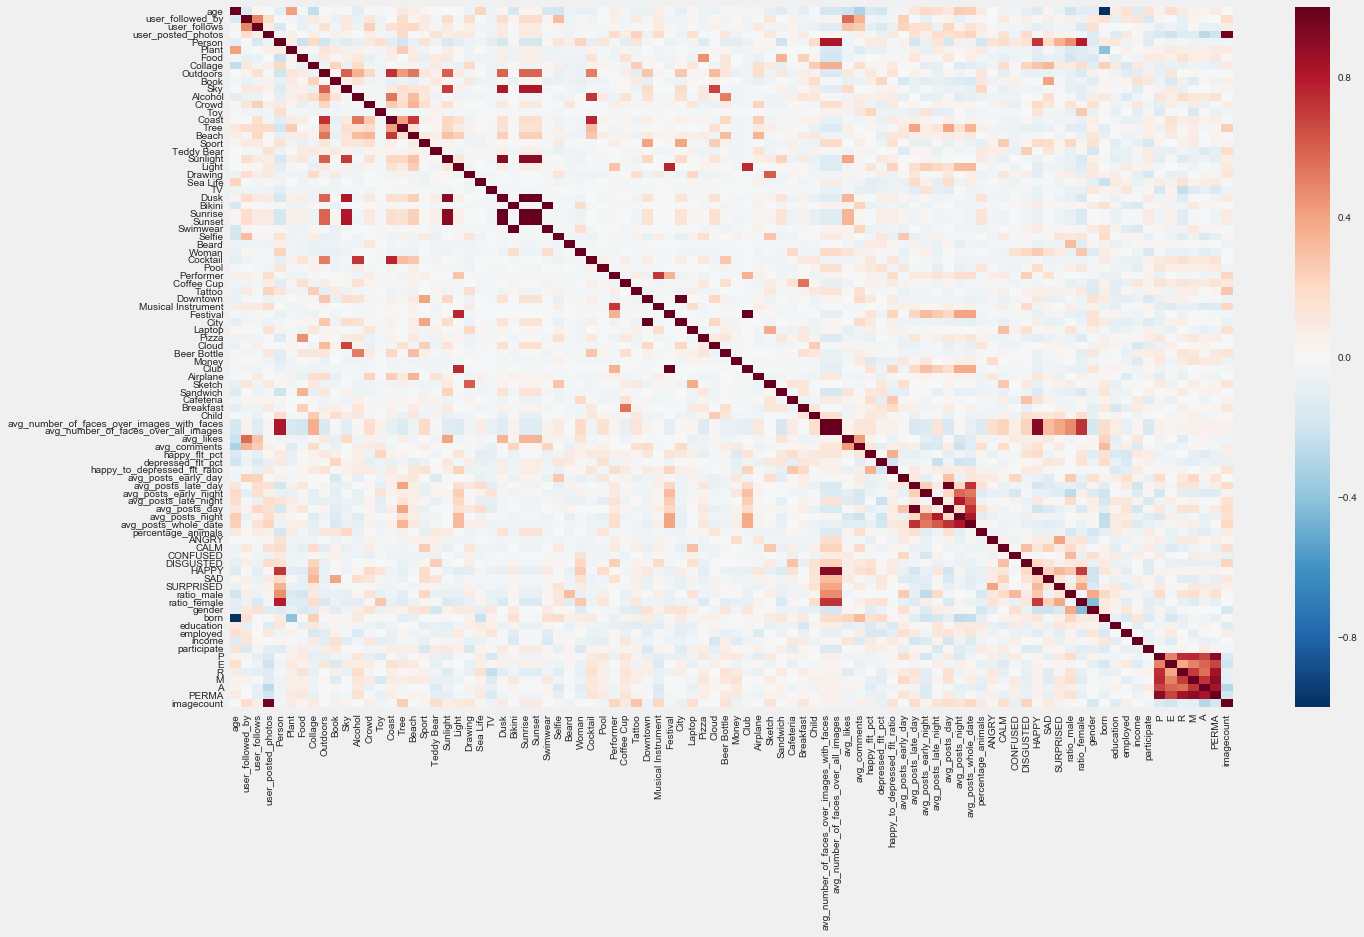

In [321]:
plt.figure(figsize=(20,12))

sns.heatmap(df.corr())

## Sparse Features

In [322]:
#threshold = 0.7

#columns = df.columns

#for column in columns:
    
    #percentage_of_zeros = len(df[df[column] == 0])/len(df)
    
    #if (percentage_of_zeros > threshold):
        
        #df = df.drop(column, axis=1)

In [323]:
df.shape

(159, 90)

## Basic Cleaning

In [324]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,159.0,30.842767,9.241167,19.000000,24.000000,29.000000,35.000000,68.000000
user_followed_by,159.0,389.106918,627.111033,0.000000,70.000000,191.000000,391.500000,4240.000000
user_follows,159.0,552.352201,1130.472020,0.000000,86.500000,210.000000,475.000000,7322.000000
user_posted_photos,159.0,278.371069,435.241073,1.000000,22.000000,100.000000,374.000000,2997.000000
Person,159.0,0.413538,0.279651,0.000000,0.189652,0.387755,0.622543,1.000000
Plant,159.0,0.038498,0.090086,0.000000,0.000000,0.020833,0.045163,1.000000
Food,159.0,0.023865,0.054885,0.000000,0.000000,0.007605,0.022604,0.500000
Collage,159.0,0.016142,0.025396,0.000000,0.000000,0.007463,0.022739,0.161905
Outdoors,159.0,0.012003,0.020507,0.000000,0.000000,0.002112,0.014418,0.130435
Book,159.0,0.004325,0.008827,0.000000,0.000000,0.000000,0.005402,0.062500


### Object Tags

### Useless Columns

## Removing Outliers

In [325]:
def gbm_grid_search(train_set, test_set, target):

    # Identify predictors and response
    x = train_set.columns
    y = target
    x.remove(y)

    # Split data into train & validation
    ss = train_set.split_frame(seed = 1)
    train = ss[0]
    valid = ss[1]

    
    # GBM hyperparameters
    gbm_params2 = {'learn_rate': [0.0001, 0.001, 0.01, 0.1],
                    'max_depth': [3, 5, 9, 25, 50, 100, 200],
                    'sample_rate': [0.5, 0.6, 0.7, 0.8, 0.9, 0.1, 0.11],
                    'col_sample_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.1, 0.11],
                    'ntrees': [10, 50, 100]}

    # Search criteria
    search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 500, 'seed': 1}

    # Train and validate a cartesian grid of GBMs
    gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                              grid_id='gbm_grid2',
                              hyper_params=gbm_params2,
                              search_criteria=search_criteria)
    gbm_grid1.train(x=x, y=y,
                    training_frame=train,
                    validation_frame=valid,
                    seed=1)

    # Get the grid results, sorted by validation AUC
    gbm_gridperf1 = gbm_grid1.get_grid(sort_by='rmsle', decreasing=True)
    gbm_gridperf1

    # Grab the top GBM model, chosen by validation AUC
    best_gbm1 = gbm_gridperf1.models[0]

    # Now let's evaluate the model performance on a test set
    # so we get an honest estimate of top model performance
    best_gbm_perf1 = best_gbm1.model_performance(test_set)

    return best_gbm1

In [326]:
h2o.remove_all()

best_model = None
pred = None
df_test = None

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8, random_state = 1)
    df_test = df_pred[~np.isin(df_pred.index, df_train.index)]
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_test)
    
    #automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)
    
    model = gbm_grid_search(h2o_train, h2o_test, 'P')
    
    pred = model.predict(h2o_test)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


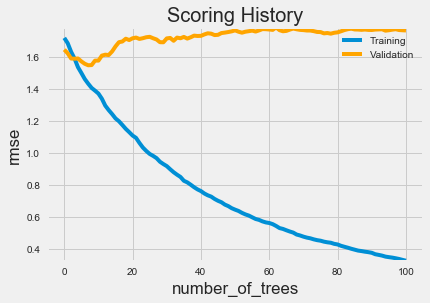

In [327]:
model.plot()

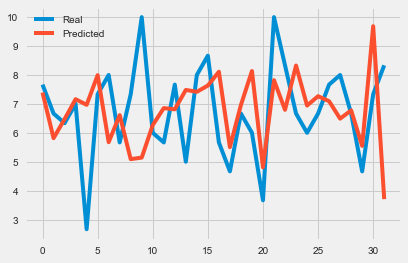

In [329]:
plt.plot(range(0,len(df_test)), (df_test.P), label='Real')
plt.plot(range(0,len(pred.as_data_frame())), (pred.as_data_frame().predict), label='Predicted')

plt.legend()

In [287]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

print(mean_absolute_error(np.exp(df_test.P), np.exp(pred.as_data_frame().predict)))

1.58173164117


In [288]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,avg_posts_night,4.831830,1.000000,0.094485
1,avg_posts_early_night,4.217983,0.872958,0.082482
2,age,3.045596,0.630319,0.059556
3,ratio_male,2.613662,0.540926,0.051110
4,Food,2.542423,0.526182,0.049716
5,born,2.457431,0.508592,0.048054
6,avg_comments,2.333194,0.482880,0.045625
7,Person,2.052628,0.424814,0.040139
8,Book,1.957801,0.405188,0.038284
9,avg_number_of_faces_over_all_images,1.767985,0.365904,0.034573


In [207]:
df_importances.scaled_importance.describe()

count    42.000000
mean      0.142656
std       0.235173
min       0.000000
25%       0.000000
50%       0.000000
75%       0.163657
max       1.000000
Name: scaled_importance, dtype: float64

In [289]:
low_importances = df_importances[df_importances.scaled_importance < 0.10]
df_reloaded = df.drop(low_importances.variable, axis=1)

In [290]:
h2o.remove_all()

best_model = None
pred = None
df_test = None

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8, random_state = 1)
    df_test = df_pred[~np.isin(df_pred.index, df_train.index)]
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_test)
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    #automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)
    
    model = gbm_grid_search(h2o_train, h2o_test, 'P')
    
    pred = model.predict(h2o_test)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


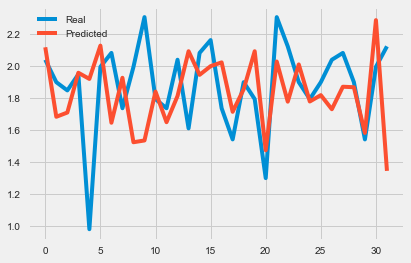

In [291]:
plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

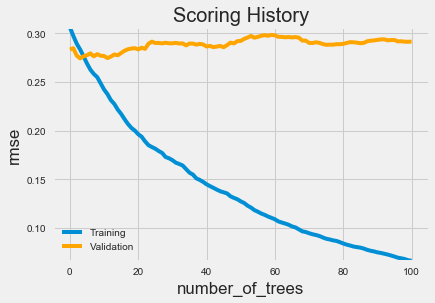

In [292]:
model.plot()

In [293]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

print(mean_absolute_error(np.exp(df_test.P), np.exp(pred.as_data_frame().predict)))

1.58717772058


In [294]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,avg_posts_early_night,4.694581,1.000000,0.096863
1,ratio_male,3.030495,0.645530,0.062528
2,avg_posts_late_night,2.991166,0.637153,0.061717
3,avg_posts_night,2.312735,0.492639,0.047719
4,percentage_animals,2.234164,0.475903,0.046097
5,avg_comments,2.230217,0.475062,0.046016
6,avg_number_of_faces_over_all_images,2.185882,0.465618,0.045101
7,age,2.161202,0.460361,0.044592
8,born,2.007822,0.427689,0.041427
9,Book,1.962475,0.418030,0.040492


In [295]:
low_importances = df_importances[df_importances.scaled_importance < 0.2]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [296]:
h2o.remove_all()

best_model = None
pred = None
df_test = None

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8, random_state = 1)
    df_test = df_pred[~np.isin(df_pred.index, df_train.index)]
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_test)
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    #automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)
    
    model = gbm_grid_search(h2o_train, h2o_test, 'P')
    
    pred = model.predict(h2o_test)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


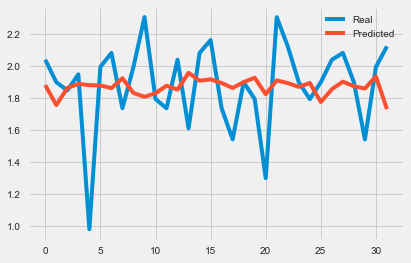

In [297]:
plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [254]:
model.model_performance(test_data = h2o_test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 2.5892688238387325
RMSE: 1.6091205125281116
MAE: 1.2315999647834026
RMSLE: 0.23020250965766995
Mean Residual Deviance: 2.5892688238387325


In [257]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,ratio_male,79.090836,1.000000,0.157043
1,avg_posts_early_night,59.504543,0.752357,0.118152
2,avg_posts_night,47.171162,0.596418,0.093663
3,age,44.837868,0.566916,0.089030
4,born,40.192890,0.508186,0.079807
5,Book,38.624912,0.488361,0.076694
6,avg_comments,36.941708,0.467079,0.073351
7,avg_number_of_faces_over_all_images,28.250092,0.357185,0.056093
8,ratio_female,21.908411,0.277003,0.043501
9,happy_to_depressed_flt_ratio,17.775955,0.224754,0.035296


In [258]:
df_importances.scaled_importance.describe()

count    25.000000
mean      0.254708
std       0.271740
min       0.000000
25%       0.052986
50%       0.197211
75%       0.467079
max       1.000000
Name: scaled_importance, dtype: float64

In [259]:
low_importances = df_importances[df_importances.scaled_importance < 0.01]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [260]:
h2o.remove_all()

best_model = None
pred = None
df_test = None

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8, random_state = 1)
    df_test = df_pred[~np.isin(df_pred.index, df_train.index)]
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_test)
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    #automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)
    
    model = gbm_grid_search(h2o_train, h2o_test, 'P')
    
    pred = model.predict(h2o_test)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


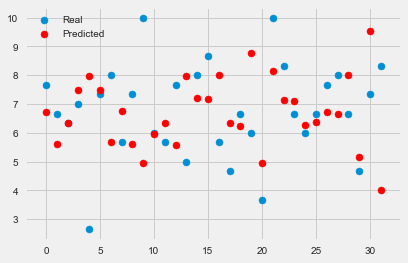

In [265]:
plt.scatter(range(0,len(df_test)), df_test.P, label='Real')
plt.scatter(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted', color='red')

plt.legend()

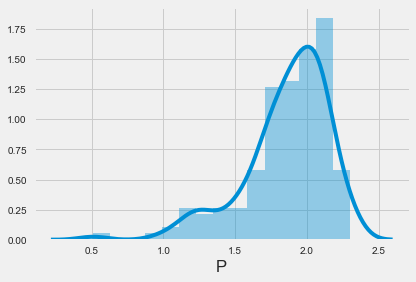

In [274]:
sns.distplot(np.log(df_reloaded.P))

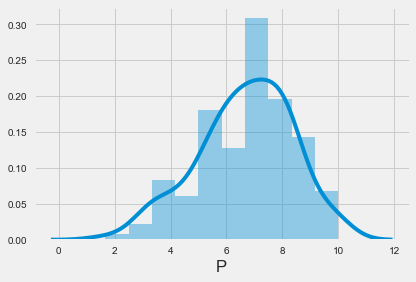

In [275]:
sns.distplot(df_reloaded.P)